### Importing necessary Python libraries

In [3]:
### Keep This Part Unchanged

# importing the libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image

# for reading and augmenting images
from skimage.io import imread
from skimage.transform import rotate, resize

# for splitting train-test set and evaluating the model
from sklearn.metrics import accuracy_score

# PyTorch libraries
import torch
from torch.optim import Adam
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn import Linear, BCEWithLogitsLoss

### Read in dataset from dropbox

In [ ]:
### Keep This Part Unchanged
### Read in dataset from dropbox

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

from os.path import exists
if exists("/content/drive/MyDrive/data.zip")==False:
  !wget -P /content/drive/MyDrive/ https://www.dropbox.com/s/8gf8whinebhbuth/data.zip
  !unzip /content/drive/MyDrive/data.zip -d /content/drive/MyDrive/

Mounted at /content/drive


----------------------------------------------------------------------------------------------------------------

### Define property of a dataset for classification

In [ ]:
### Keep This Part Unchanged

class classificationDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### Define image augmentation strategies
* Try different augmentation as follows to the train_transformation for Question3

In [ ]:
train_transformation = transforms.Compose([transforms.RandomHorizontalFlip()])
test_transformation = transforms.Compose([])

img_path = '/content/drive/MyDrive/data/small_CCIC'
train_annotations = '/content/drive/MyDrive/data/csv/train_anns.csv'
test_annotations = '/content/drive/MyDrive/data/csv/test_anns.csv'

training_data = classificationDataset(train_annotations, img_path, transform=train_transformation)
test_data = classificationDataset(test_annotations, img_path, transform=test_transformation)

# batch size of the model
# Try different batch size
bs = 16

train_dataloader = DataLoader(training_data, batch_size=bs, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=bs)

print("Number of images (After Image Augmentation) in Training set : ",len(training_data),"  Number of images in Testing set : ", len(test_data))

Number of images (After Image Augmentation) in Training set :  600   Number of images in Testing set :  200


###  Creating data loaders for image classification model

Feature batch shape: torch.Size([16, 3, 32, 32])
Labels batch shape: torch.Size([16])


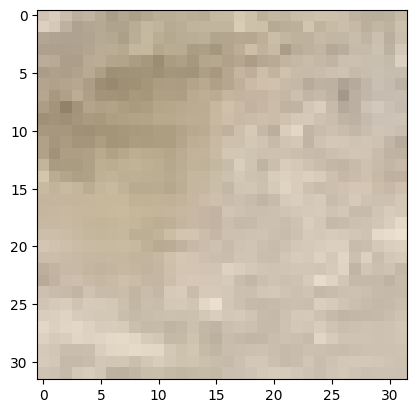

Label: 0


In [ ]:
### Keep This Part Unchanged
# Display image and label.
train_features, train_labels = next(iter(test_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
img_t = img.permute(1,2,0)
plt.imshow(img_t)
plt.show()
print(f"Label: {label}")

-------------------

### Training a ResNet50 model for binary image classification using PyTorch
* Tips: You do not need to build the model by yourself from scratch. Please complete the hyperparameter tuning, augmentation strategy adjustment, and other relevant explorations for Question 1-3 based on the model provided below.
* Tips: Please add code cell or text cell below, indicating the corresponding question number, to complete the respective question.

# **Important Disclaimer:**
 After conducting the project many times and running I realised that there is an inherant randomness to the process. This is indeed the case when building a CNN. There is a stochastic probablity that nutuarally arises. In order to mitigate and avoid any uncertainy in the result (that would change after iteration), I have decided to **run the file for 10 iterations** and takes the average of all the results of the accuracy to get the most representative result possible.

For every question. you will find the results of the final iteration (iteration 12) followed by a sperated cell with the results of all the previous iterations and the average, then a cell where I analyze the results.

# **Question 1**

In [ ]:
import matplotlib.pyplot as plt


# Define different learning rates
learning_rates = [0.005, 0.0005, 0.00005]  # Smaller, original, greater


# prediction for training set
# Initialize lists to store losses for each learning rate
training_losses = []
test_losses = []
#Number of epochs
n_epochs = 15

# Loop over different learning rates
for lr in learning_rates:
    # Define and initialize a model
    num_classes = 1
    Net = models.resnet50()
    Net.fc = Linear(2048, num_classes)
    # Define and initialize model with different learning rates
    model = Net
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = BCEWithLogitsLoss()

    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Start training loop
    training_loss_epochs = []
    test_loss_epochs = []
    for epoch in range(1, n_epochs+1):
        model.train()
        train_loss = 0.0
        training_loss = []
        for _, (x, y) in enumerate(train_dataloader):
            x = x.float() # x is byte Tensor (8-bit integer)
            y = y.float()
            x, y = x.to(device), y.to(device)

            output = model(x).squeeze()
            loss = criterion(output, y)

            training_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        training_loss = np.average(training_loss)
        training_loss_epochs.append(training_loss)


        # Evaluate on test set
        model.eval()
        test_loss = 0.0
        testing_loss = []
        prediction_test = []
        target_test = []
        with torch.no_grad():
            for _, (x_test, y_test) in enumerate(test_dataloader):
                x_test = x_test.float().to(device)
                y_test = y_test.float().to(device)

                output_test = model(x_test).squeeze()
                loss_test = criterion(output_test, y_test)
                testing_loss.append(loss_test.item())
                predictions = torch.sigmoid(output_test ).cpu().numpy()
                predictions = predictions>0.5
                predictions = predictions.astype('uint8')

                prediction_test.append(predictions)
                target_test.append(y_test.cpu())

        test_loss = np.average(testing_loss)
        test_loss_epochs.append(test_loss)

        print(f'Learning Rate: {lr}, Epoch: {epoch}, Training Loss: {training_loss}, Test Loss: {test_loss}')
    # Test accuracy
    accuracy_test = []
    for i in range(len(prediction_test)):
        accuracy_test.append(accuracy_score(target_test[i], prediction_test[i]))
    print('Test accuracy: \t', np.average(accuracy_test))
    # Append training and test losses for this learning rate to the main lists
    training_losses.append(training_loss_epochs)
    test_losses.append(test_loss_epochs)


Learning Rate: 0.005, Epoch: 1, Training Loss: 0.8967234092323404, Test Loss: 9.821164936543656
Learning Rate: 0.005, Epoch: 2, Training Loss: 0.4445615207874461, Test Loss: 0.5715470311160271
Learning Rate: 0.005, Epoch: 3, Training Loss: 0.1660917021922375, Test Loss: 0.7106951375026256
Learning Rate: 0.005, Epoch: 4, Training Loss: 0.15431744620007903, Test Loss: 0.1260235604758446
Learning Rate: 0.005, Epoch: 5, Training Loss: 0.3931101024837086, Test Loss: 170798.90745192306
Learning Rate: 0.005, Epoch: 6, Training Loss: 0.5606857522537834, Test Loss: 1.2607065873363843
Learning Rate: 0.005, Epoch: 7, Training Loss: 0.47256155998299, Test Loss: 0.6632848215790895
Learning Rate: 0.005, Epoch: 8, Training Loss: 0.4170911874328005, Test Loss: 0.49973270812859905
Learning Rate: 0.005, Epoch: 9, Training Loss: 0.7563875835192831, Test Loss: 0.7079442346898409
Learning Rate: 0.005, Epoch: 10, Training Loss: 0.5952670334005042, Test Loss: 0.578092706318085
Learning Rate: 0.005, Epoch: 11

In [3]:
# Average Accuracy for 12 iterations
Accuracy_lr_Big = np.array([0.9519, 0.7788, 0.9519, 0.6587, 0.7548, 0.8702,  0.9567, 0.9471, 0.9760, 0.9712, 0.8462, 0.9038])
print( 'Accuracy of model with lr=0.005 is ' + str(Accuracy_lr_Big.mean()))
print( 'Std of model with lr=0.005 is ' + str(Accuracy_lr_Big.std()))
Accuracy_lr = np.array([0.9471, 0.9760, 0.9615, 0.9520, 0.9471, 0.9567,  0.9471, 0.9615 , 0.9712, 0.9082, 0.9471, 0.9712])
print( 'Accuracy of model with lr=0.0005 is ' + str(Accuracy_lr.mean()))
print( 'Std of model with lr=0.0005 is ' + str(Accuracy_lr.std()))
Accuracy_lr_sml = np.array([0.9615, 0.9375, 0.9279, 0.8990, 0.9279, 0.9183,  0.8942, 0.9375 , 0.9087, 0.9375, 0.9279, 0.9135])
print( 'Accuracy of model with lr=0.00005 is ' + str(Accuracy_lr_sml.mean()))
print( 'Std of model with lr=0.00005 is ' + str(Accuracy_lr_sml.std()))

Accuracy of model with lr=0.005 is 0.8806083333333333
Std of model with lr=0.005 is 0.09787262520178402
Accuracy of model with lr=0.0005 is 0.9538916666666668
Std of model with lr=0.0005 is 0.017047505112348697
Accuracy of model with lr=0.00005 is 0.9242833333333333
Std of model with lr=0.00005 is 0.0179989274371805


DO ANALYSIS HERE

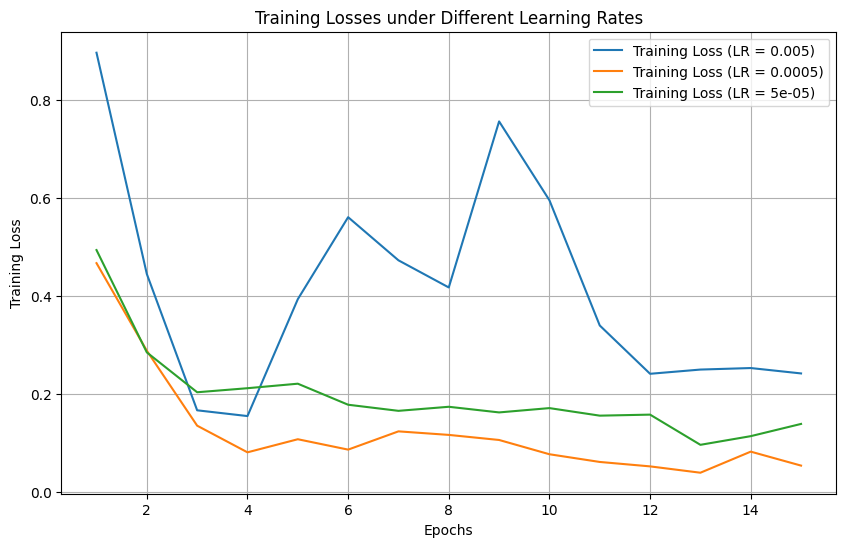

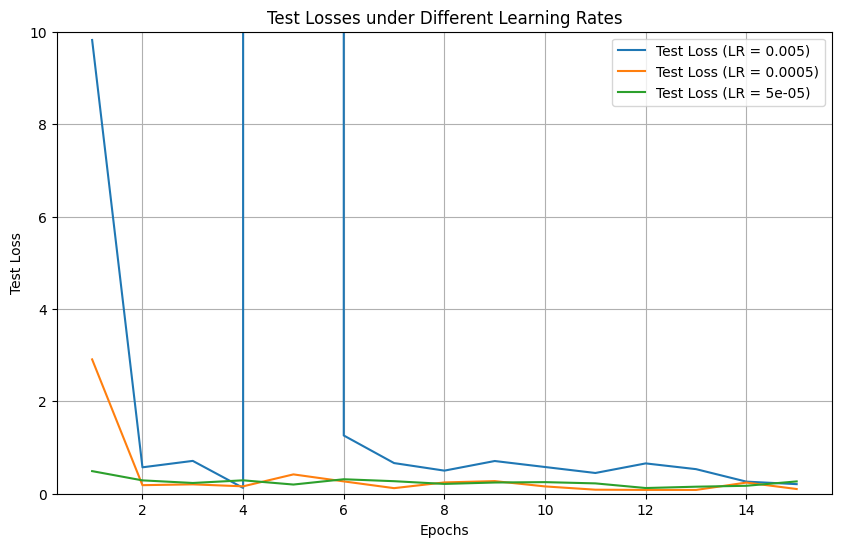

In [ ]:


# Plot training losses
plt.figure(figsize=(10, 6))
epochs = range(1, n_epochs+1)
for i, lr in enumerate(learning_rates):
    plt.plot(epochs, training_losses[i], label=f'Training Loss (LR = {lr})')

plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Losses under Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()

# Plot test losses
plt.figure(figsize=(10, 6))
for i, lr in enumerate(learning_rates):
    plt.plot(epochs, test_losses[i], label=f'Test Loss (LR = {lr})')
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.ylim(0, 10)
plt.title('Test Losses under Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()




**QUESTION 1 ANALYSIS:**

This test explores the impact of different learning rates on the final Neural Network. It is crucial to acknowledge **the compromise** when selecting the learning rate. If the learning rate is too large, the final result might not converge correctly and could be inherently unstable due to excessively large steps during optimization. Conversely, if the learning rate is too small, the neural network might converge too slowly or even to the wrong minima. Let's analyze the results obtained in our case, considering the results of all 12 iterations:

 *   **The most precise and accurate result was, unsurprisingly, achieved with the intermediate learning rate** **(lr=0.0005)**. This learning rate strikes a good balance between being sufficiently large to make progress and being conservative enough to avoid instability. The accuracy of this learning rate is **0.96** compared to **0.88** for the larger learning rate **(lr=0.005)** and **0.92** for the smaller one **(5e-5)**. **While the difference is significant, it is not game-changing**.

*  For **the larger learning rate**, the gradient step is too large for it to converge properly and accurately. Quite the opposite happens, **as the larger learning rate proves to be unstable.** This instability is evidenced by:
   1. The **average accuracy** of the model with the larger learning rate   is **significantly smaller** than the other models.
   2. The **standard deviation of the accuracy** of the model with the larger learning rate is **significantly larger** (nearly six times bigger with a standard deviation of 0.098 vs. 0.017). In other words, the results of the accuracy of the larger learning rate model vary greatly each time the file runs, indicating instability.
   3. Finally, by examining the loss plot for both the test losses and the training, we notice that for both cases, the losses of the model with **the larger learning rate fluctuate and jump in an unpredictable and unexpected way**. This further illustrates the instability of the convergence with a learning rate that is too large.

* On the other hand, for **the smaller learning rate (5e-5)**, instability is not a problem. However, **the convergence is too slow**. This is reflected in the slightly inferior accuracy but can also be seen visually in the plot. The green line always remains above the yellow one because the green line converges slower than the yellow one, resulting in a higher loss. Although the smaller learning rate is better than the very large one (because it is stable), it performs worse than the intermediate one, which can converge to a lower final loss and achieve better accuracy.








# **Question 2**

In [ ]:


# Initialize lists to store losses for each learning rate
training_losses = []
test_losses = []
training_loss_epochs = []
test_loss_epochs = []

# Define and initialize a model
num_classes = 1
Net = models.resnet50()
Net.fc = Linear(2048, num_classes)

# Define training option
# Try different learning rate
model_2 = Net
optimizer = Adam(model_2.parameters(), lr=0.0005)
criterion = BCEWithLogitsLoss()

# checking if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_2 = model_2.to(device)

# Start training
# number of epochs to train the model
n_epochs = 60

torch.cuda.empty_cache()

for epoch in range(1, n_epochs+1):
    model_2.train()
    train_loss = 0.0
    training_loss = []
    for _, (x, y) in enumerate(train_dataloader):
        x = x.float() # x is byte Tensor (8-bit integer)
        y = y.float()
        x, y = x.to(device), y.to(device)

        output = model_2(x).squeeze()
        loss = criterion(output, y)

        training_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    training_loss = np.average(training_loss)
    print('epoch: \t', epoch, '\t training loss: \t', training_loss)

epoch: 	 1 	 training loss: 	 0.4470851813492022
epoch: 	 2 	 training loss: 	 0.23911957293258687
epoch: 	 3 	 training loss: 	 0.1508540614189482
epoch: 	 4 	 training loss: 	 0.20708568642945274
epoch: 	 5 	 training loss: 	 0.11641643844593905
epoch: 	 6 	 training loss: 	 0.14916061897958188
epoch: 	 7 	 training loss: 	 0.11922218209426654
epoch: 	 8 	 training loss: 	 0.11792008835503734
epoch: 	 9 	 training loss: 	 0.05914842357589422
epoch: 	 10 	 training loss: 	 0.12385584695240189
epoch: 	 11 	 training loss: 	 0.07845255407798839
epoch: 	 12 	 training loss: 	 0.044164574913386455
epoch: 	 13 	 training loss: 	 0.0495352117945195
epoch: 	 14 	 training loss: 	 0.05293971694405436
epoch: 	 15 	 training loss: 	 0.13420619366776296
epoch: 	 16 	 training loss: 	 0.07336617223183184
epoch: 	 17 	 training loss: 	 0.044013707359370435
epoch: 	 18 	 training loss: 	 0.05055183569876183
epoch: 	 19 	 training loss: 	 0.03206502107940124
epoch: 	 20 	 training loss: 	 0.04598702

In [ ]:
# prediction for training set

model_2.eval()
test_loss = 0.0
testing_loss = []
prediction_test = []
target_test = []
predictions = []
with torch.no_grad():
    for _, (x, y) in enumerate(test_dataloader):
        x = x.float() # x is byte Tensor (8-bit integer)
        y = y.float()
        x, y = x.to(device), y.to(device)

        y_pred = model_2(x)
        predictions = torch.sigmoid(y_pred).cpu().numpy()
        predictions = predictions>0.5
        predictions = predictions.astype('uint8')
        prediction_test.append(predictions)
        target_test.append(y.cpu())
# Test accuracy
accuracy_test = []
for i in range(len(prediction_test)):
    accuracy_test.append(accuracy_score(target_test[i], prediction_test[i]))

print('Test accuracy: \t', np.average(accuracy_test))


Test accuracy: 	 0.9807692307692307


In [ ]:
Accuracy_2 = np.array([0.9615, 0.5385, 0.9712, 0.9663, 0.9808, 0.9712, 0.9663, 0.9615, 0.9760, 0.9471, 0.9529, 0.9808 ])
print( 'Accuracy of model 2 is ' + str(Accuracy_2.mean()))

Accuracy of model 2 is 0.931175


 **QUESTION 2 ANALYSIS:**

The model used here is **the same as the previous one** with an intermediate learning rate of 0.0005. The only difference is that this **model is trained for 60 epochs instead of 15 epochs**. Both the training data and the test data are identical.

The result obtained here is that **the accuracy of the 2nd model** (Question 2) on the testing data is **0.93**, which is **lower** than the **0.97** of the first model.

This is a significant result that can be interpreted. Initially, one might expect the model trained with more epochs to be more accurate as it has more information contained within it. However, in our case, we realize that the accuracy is lower for the 2nd model. This can simply be explained by the phenomenon of **overfitting.**

Indeed, the 2nd model performs better on the training dataset, but it is too tailored to the training dataset. This, counterintuitively, yields worse results for the test dataset. Overfitting occurs when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data.

# **Question 3**

In [ ]:

train_transformation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30)
])
test_transformation = transforms.Compose([])

# Try different augmentation as follows to the train_transformation for Question3(a):
# transforms.RandomHorizontalFlip(),
# transforms.RandomVerticalFlip(),
# transforms.RandomRotation(30)

img_path = '/content/drive/MyDrive/data/small_CCIC'
train_annotations = '/content/drive/MyDrive/data/csv/train_anns.csv'
test_annotations = '/content/drive/MyDrive/data/csv/test_anns.csv'

training_data = classificationDataset(train_annotations, img_path, transform=train_transformation)
test_data = classificationDataset(test_annotations, img_path, transform=test_transformation)


train_dataloader = DataLoader(training_data, batch_size=bs, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=bs)

print("Number of images (After Image Augmentation) in Training set : ",len(training_data),"  Number of images in Testing set : ", len(test_data))




# Define and initialize a model
num_classes = 1
Net = models.resnet50()
Net.fc = Linear(2048, num_classes)

# Define training option
# Try different learning rate
model_3 = Net
optimizer = Adam(model_3.parameters(), lr=0.0005)
criterion = BCEWithLogitsLoss()

# checking if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_3 = model_3.to(device)

# Start training
# number of epochs to train the model
n_epochs = 60
predictions =[]
torch.cuda.empty_cache()

for epoch in range(1, n_epochs+1):
    model_3.train()

    train_loss = 0.0
    training_loss = []
    for _, (x, y) in enumerate(train_dataloader):
        x = x.float() # x is byte Tensor (8-bit integer)
        y = y.float()
        x, y = x.to(device), y.to(device)

        output = model_3(x).squeeze()
        loss = criterion(output, y)

        training_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    training_loss = np.average(training_loss)
    print('epoch: \t', epoch, '\t training loss: \t', training_loss)


# prediction for training set
prediction_test = []
target_test = []

model_3.eval()
with torch.no_grad():
    for _, (x, y) in enumerate(test_dataloader):
        x = x.float() # x is byte Tensor (8-bit integer)
        y = y.float()
        x, y = x.to(device), y.to(device)

        y_pred = model_3(x)
        predictions = torch.sigmoid(y_pred).cpu().numpy()
        predictions = predictions>0.5
        predictions = predictions.astype('uint8')
        prediction_test.append(predictions)
        target_test.append(y.cpu())
# Test accuracy
accuracy_test = []
for i in range(len(prediction_test)):
    accuracy_test.append(accuracy_score(target_test[i], prediction_test[i]))

print('Test accuracy: \t', np.average(accuracy_test))

Number of images (After Image Augmentation) in Training set :  600   Number of images in Testing set :  200
epoch: 	 1 	 training loss: 	 0.5365429777455958
epoch: 	 2 	 training loss: 	 0.3427264731573431
epoch: 	 3 	 training loss: 	 0.23976383304321452
epoch: 	 4 	 training loss: 	 0.1709596380762952
epoch: 	 5 	 training loss: 	 0.13065575217632086
epoch: 	 6 	 training loss: 	 0.1444267390884067
epoch: 	 7 	 training loss: 	 0.10109100488663994
epoch: 	 8 	 training loss: 	 0.12458301409098663
epoch: 	 9 	 training loss: 	 0.15102437719408618
epoch: 	 10 	 training loss: 	 0.14680744067912824
epoch: 	 11 	 training loss: 	 0.10485009372994107
epoch: 	 12 	 training loss: 	 0.11331033241616464
epoch: 	 13 	 training loss: 	 0.10296246139822822
epoch: 	 14 	 training loss: 	 0.06797851025322943
epoch: 	 15 	 training loss: 	 0.11132871982102331
epoch: 	 16 	 training loss: 	 0.09296050229673519
epoch: 	 17 	 training loss: 	 0.10929950514171076
epoch: 	 18 	 training loss: 	 0.08677

In [ ]:
Accuracy_3 = np.array([0.9663, 0.9904, 0.9327, 0.9712, 0.9759, 0.9904, 0.9808, 0.9760, 0.9856, 0.9375, 0.9615, 0.9664 ])
print( 'Accuracy of model 3 is ' + str(Accuracy_3.mean()))

Accuracy of model 2 is 0.9695583333333332


**QUESTION 3-a ANALYSIS :**

The model trained in this case (model 3) **has the same exact paramters as model 2**. The only slight difference is that the **training data has been slightly modified** with the following commands :
```
train_transformation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30)
])
```
This is known as an **augmentation strategy**. The goal is to make the input images of the training dataset **more diverse and random**. In turn, this allows the model to expect a bit of the unexpected (even though it is artificially generated unexpectedness). In general, adding this more random parameter allows for better performance on the test dataset.

In our case, we observe a **slight improvement in accuracy** from the 2nd model, with an increase from **0.93 to 0.97**. This improvement is significant and indicates that **the augmentation strategy worked and improved the final neural network on the test dataset**. It is noteworthy that even with this slight improvement, the model performs on the same level (or even negligibly worse) than the first model, which equally has an accuracy of 0.97. The augmentation strategy was able to mitigate the overfitting of Question 2 but did not outperform the model that did not overfit.





In [ ]:

# Define training option with weight decay


# Define and initialize a model
num_classes = 1
Net = models.resnet50()
Net.fc = Linear(2048, num_classes)

# Define training option
# Try different learning rate
model_3_b = Net
optimizer = Adam(model_3_b.parameters(), lr=0.0005, weight_decay=0.0001)
criterion = BCEWithLogitsLoss()

# checking if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_3_b = model_3_b.to(device)

# Start training
# number of epochs to train the model
n_epochs = 60
predictions =[]
torch.cuda.empty_cache()

for epoch in range(1, n_epochs+1):
    model_3_b.train()

    train_loss = 0.0
    training_loss = []
    for _, (x, y) in enumerate(train_dataloader):
        x = x.float() # x is byte Tensor (8-bit integer)
        y = y.float()
        x, y = x.to(device), y.to(device)

        output = model_3_b(x).squeeze()
        loss = criterion(output, y)

        training_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    training_loss = np.average(training_loss)
    print('epoch: \t', epoch, '\t training loss: \t', training_loss)


# prediction for training set
prediction_test = []
target_test = []

model_3_b.eval()
with torch.no_grad():
    for _, (x, y) in enumerate(test_dataloader):
        x = x.float() # x is byte Tensor (8-bit integer)
        y = y.float()
        x, y = x.to(device), y.to(device)

        y_pred = model_3_b(x)
        predictions = torch.sigmoid(y_pred).cpu().numpy()
        predictions = predictions>0.5
        predictions = predictions.astype('uint8')
        prediction_test.append(predictions)
        target_test.append(y.cpu())
# Test accuracy
accuracy_test = []
for i in range(len(prediction_test)):
    accuracy_test.append(accuracy_score(target_test[i], prediction_test[i]))

print('Test accuracy: \t', np.average(accuracy_test))

epoch: 	 1 	 training loss: 	 0.46051603957618537
epoch: 	 2 	 training loss: 	 0.2717004159563466
epoch: 	 3 	 training loss: 	 0.16639107215757432
epoch: 	 4 	 training loss: 	 0.27484364998771954
epoch: 	 5 	 training loss: 	 0.16814862948989398
epoch: 	 6 	 training loss: 	 0.14045421761999788
epoch: 	 7 	 training loss: 	 0.11985271149560024
epoch: 	 8 	 training loss: 	 0.1181048300656441
epoch: 	 9 	 training loss: 	 0.10981431587501184
epoch: 	 10 	 training loss: 	 0.13456641252789842
epoch: 	 11 	 training loss: 	 0.06768079261344515
epoch: 	 12 	 training loss: 	 0.06714676905692996
epoch: 	 13 	 training loss: 	 0.11199112585439396
epoch: 	 14 	 training loss: 	 0.11545689919914462
epoch: 	 15 	 training loss: 	 0.06785422619922381
epoch: 	 16 	 training loss: 	 0.06215350834750816
epoch: 	 17 	 training loss: 	 0.06201401321634062
epoch: 	 18 	 training loss: 	 0.0901131288908226
epoch: 	 19 	 training loss: 	 0.08462033484216877
epoch: 	 20 	 training loss: 	 0.0756878211

In [4]:
Accuracy_3_b = np.array([0.9423, 0.9807, 0.9423, 0.9663, 0.9856, 0.9856, 0.9860, 0.9567, 0.9759, 0.9519, 0.9712, 0.9472 ])
print( 'Accuracy of model 3_b is ' + str(Accuracy_3_b.mean()))

Accuracy of model 3_b is 0.9659749999999999


**ANALYSIS OF QUESTION 3-b :**

This last model (Model 3b) uses the **same exact parameters and inputs** as the previous model (Model 3). The only difference is that we add **regularization **to further prevent overfitting. A **weight decay of 0.0001 **is used. Regularization is an important technique to prevent model **overfitting**.

Despite the expectation of seeing an improvement in the final accuracy, an interesting thing happens here: **we don't observe an improvement**. Quite the opposite, **we see a decrease in the final accuracy from 0.97 to 0.966.**

Potential **reasons** for the unexpected result:

*  **Aggressive Regularization**: Regularization, such as weight decay, is a technique used during the training of neural networks to prevent overfitting. Weight decay adds a penalty term to the loss function, forcing the model to keep the weights small. **However, in this case, it seems that the weight decay of 0.0001 was too aggressive, leading the model to underfit the data**. As a result, the model's ability to capture the underlying patterns in the data was compromised, leading to a decrease in accuracy.
*   **Augmentation and Regularization Interaction:** Another potential reason for this unexpected result could be that the combination of augmentation and regularization techniques interacted in an unexpected way. While augmentation aims to increase the diversity of the training dataset, regularization, such as weight decay, aims to prevent overfitting. **The weight decay used in this scenario might have been too strong, combined with the diversity introduced by augmentation, leading to an underfitting scenario.**

Other regularization methods include:
* **Dropout:** Dropout is a regularization technique where randomly selected neurons are ignored during training. This forces the network to learn more robust features.
* **L1 and L2 regularization:** In addition to weight decay, which is a form of L2 regularization, L1 regularization adds a penalty term to the loss function proportional to the absolute value of the weights. This encourages sparsity in the model's weights.

By introducing one of these regularization methods, we can enhance the model's ability to generalize and thus improve its performance on unseen data.